# Spectral type flagger and star physical quantities Probability Distribution Functions (star-PDF)

In [2]:
### Import libraries ###
import re
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In another script, we developped a PDFstar flagger which assumes the spectral type of a star by looking at the best fit of a onesource object over a star template. We used a 1 dimensional, and limited, sed lib which was to cover smoothly the entire specter of star spectral-types (from O to M and with a few white dwarves). 

Looking at the functionning of Lephare to determine photo-z, when we use the minimal Chi2 method, we determine the type of galaxy at a pecular redshift, so we fit a source to a 2D grid.

Aside that, there is three main quantities that determine the atmosphere of a star : Surface temperature (**Teff**), Mass or gravity (**log(g)**) and composition or metallicity (**Fe/H**).

Taking these informations into account, we can use the same logic as the one used to compute the photo-z of a source but to determine the spectral-type of a star. Hence, this time we want to use a more complete 2D or 3D grid of star sed.

Thus we pre-made a star sed library for Lephare that covers every knew type of star with those physical quantities, and run lephare onto it.

To works, it is important to have written the specs of the utilized seds either in the respective file name or in a commmented header. 

## The SED grid(s)

Note: sed grids are not perfectly square or cubic: some simulated sed are unrealistic, for example it is unsual to see a O-type star with a high metallicity. It would be a loss of time to compute the minimal Chi2 of a fit of a onesource to such a sed. Thus the sed grids are truncated at specific Teff values.

**Teff** vs **log(g)** at **Fe/H** = 0

**Teff** vs **log(g)** vs **Fe/H**

## Retrieving full star Chi2 distribution

During its processing, the only way to identify which template(s) has been used to compute the quantities relative to a onesource it's their Id. This Id is assigned when creating the sed library (with the SedLib part of the code), and is useful to retrieve the sed during or at the end of the process. 

A notable difference between the PDZ and the star-PDF is that the first one is computed from a grid that has been created thanks to the MagLab part of the code, while the star-PDF will be made from a already full 2D or 3D grid. Which means that we need to "remember" the Id of each seds to re-order them in the good way to have a smooth functionning PDF.



So first we need functions to retrieve the physical quanities relative to a sed (**Teff**, **log(g)** and **Fe/H**) thanks to its Id.

In [148]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

class STAR_PDF:
    def __init__(self, list_path):
        """Load SED list."""
        sed_list = []
        with open(list_path, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('#') or not line:
                    continue
                filepath = line.split()[0]
                sp_type = filepath.split('/')[-1].replace('.sed', "")
                sed_list.append(sp_type)
        self.sed_list = sed_list
        self.sed_grid = None

    def make_sed_grid(self):
        """Build the sed grid [Id, Teff, logg, FeH] from filenames."""
        pattern = r"Teff([-\d\.]+)_logg([-\d\.]+)_FeH([-\d\.]+)"
        sed_grid = []
        for Id, s in enumerate(self.sed_list):
            match = re.search(pattern, s)
            if match:
                Teff, logg, FeH = match.groups()
                Teff, logg, FeH = float(Teff), float(logg), float(FeH)
                sed_grid.append([Id, Teff, logg, FeH])
        self.sed_grid = np.array(sed_grid)
        return self.sed_grid

    def plot_sed_grid(self, cmap='gnuplot', s=10):
        """Plot 3D SED grid with color depending on FeH."""
        if self.sed_grid is None:
            raise ValueError("Call make_sed_grid before plot.")

        Teff, logg, FeH = self.sed_grid[:, 1], self.sed_grid[:, 2], self.sed_grid[:, 3]

        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(projection='3d')

        # Couleur selon la métallicité
        sc = ax.scatter(
            Teff, logg, FeH,
            c=FeH, cmap=cmap,
            alpha=0.8, s=s, edgecolor="none"
        )

        # Colorbar
        cbar = plt.colorbar(sc, ax=ax, pad=0.1, shrink=0.8)
        cbar.set_label('[Fe/H]', rotation=270, labelpad=15)

        ax.set_xlabel('Teff [K]')
        ax.set_ylabel('log(g)')
        ax.set_zlabel('[Fe/H]')
        ax.set_title("SED Grid Colored by Metallicity")

        # Optionnel : meilleure orientation par défaut
        ax.view_init(elev=20, azim=-45)

        plt.tight_layout()
        plt.show()


    def build_chi2_grid(self, chi2_array):
        """Matches sed grid and Chi2 values."""
        if self.sed_grid is None:
            raise ValueError("Call make_sed_grid before build.")
        if len(chi2_array) != len(self.sed_grid):
            raise ValueError("chi2 array length does not match sed_grid length.")
        return np.column_stack((self.sed_grid, chi2_array))

    def project_min_chi2(self, grid, xaxis="Teff", yaxis=None, to_prob=False):
        """
        Project Chi² parallel to one or two axes.
        - If only xaxis, return 1D PDF: min(Chi²) on the other axes.
        - If x & yaxis, return 2D PDF: min(Chi²) on the remaining axis.
        """
        columns = ["Id", "Teff", "logg", "FeH", "Chi2"]
        col_idx = {k: i for i, k in enumerate(columns)}

        xcol = col_idx[xaxis]

        if yaxis:
            ycol = col_idx[yaxis]

            X_vals = np.unique(grid[:, xcol])
            Y_vals = np.unique(grid[:, ycol])
            Z = np.full((len(Y_vals), len(X_vals)), np.nan)

            for i, xv in enumerate(X_vals):
                for j, yv in enumerate(Y_vals):
                    mask = np.isclose(grid[:, xcol], xv) & np.isclose(grid[:, ycol], yv)
                    if np.any(mask):
                        Z[j, i] = np.nanmin(grid[mask, -1])

            if to_prob:
                Zmin = np.nanmin(Z)
                Z = np.exp(-0.5 * (Z - Zmin))
            return X_vals, Y_vals, Z

        else:
            X_vals = np.unique(grid[:, xcol])
            Z = np.full(len(X_vals), np.nan)
            for i, xv in enumerate(X_vals):
                mask = np.isclose(grid[:, xcol], xv)
                if np.any(mask):
                    Z[i] = np.nanmin(grid[mask, -1])

            if to_prob:
                Zmin = np.nanmin(Z)
                Z = np.exp(-0.5 * (Z - Zmin))
            return X_vals, Z

    def plot_min_chi2(self, grid, xaxis="Teff", yaxis=None, to_prob=False, full=False, cmap='gnuplot'):
        """
        Plot the 1D or 2D PDF according to chosen axis.
        If full=True, create a corner plot layout with gridspec showing all projections.
        """
        if full:
            axes = ["Teff", "logg", "FeH"]
            n = len(axes)

            # Pré-calculer les plages de valeurs pour uniformiser les axes
            limits = {}
            for ax in axes:
                limits[ax] = np.unique(grid[:, {"Teff": 1, "logg": 2, "FeH": 3}[ax]])
            
            fig = plt.figure(figsize=(8, 8))
            gs = plt.GridSpec(n, n, wspace=0.0, hspace=0.0)

            for i in range(n):  # ligne
                for j in range(n):  # colonne
                    if j > i:
                        continue
                    ax = fig.add_subplot(gs[i, j])

                    if i == j:
                        # --- PDF 1D ---
                        X, Z = self.project_min_chi2(grid, xaxis=axes[j], to_prob=to_prob)
                        if to_prob:
                            Z = np.exp(-0.5 * (Z - np.nanmin(Z)))
                        ax.plot(X, Z, color='black', lw=1)
                        # ax.fill_between(X, Z, color='C0', alpha=0.4)
                        ax.set_xlim(limits[axes[j]].min(), limits[axes[j]].max())
                        ax.set_ylim(Z.min() * 0.95, Z.max() * 1.05)
                        if i < n - 1:
                            ax.set_xticklabels([])
                        if i != 0:
                            ax.set_yticks([])
                        else:
                            ax.set_xlabel(axes[j])

                    else:
                        # --- PDF 2D ---
                        X, Y, Z = self.project_min_chi2(grid, xaxis=axes[j], yaxis=axes[i])
                        if to_prob:
                            Z = np.exp(-0.5 * (Z - np.nanmin(Z)))
                        im = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
                        ax.set_xlim(limits[axes[j]].min(), limits[axes[j]].max())
                        ax.set_ylim(limits[axes[i]].min(), limits[axes[i]].max())
                        if i < n - 1:
                            ax.set_xticklabels([])
                        else:
                            ax.set_xlabel(axes[j])
                        if j > 0:
                            ax.set_yticklabels([])
                        else:
                            ax.set_ylabel(axes[i])

            # Colorbar
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            cbar = fig.colorbar(im, cax=cbar_ax)
            cbar.set_label("Probability" if to_prob else "min(χ²)")
            plt.subplots_adjust(left=0.08, right=0.9, top=0.9, bottom=0.08)
            plt.show()
            return


        # --- Single plot mode
        if yaxis:
            X, Y, Z = self.project_min_chi2(grid, xaxis, yaxis, to_prob=to_prob)
            plt.figure(figsize=(6, 4))
            plt.pcolormesh(X, Y, Z, shading='auto')
            plt.colorbar(label="Probability" if to_prob else "min(Chi²)")
            plt.xlabel(xaxis)
            plt.ylabel(yaxis)
            plt.title(f"Minimized Chi² map")
            plt.show()
        else:
            X, Z = self.project_min_chi2(grid, xaxis, to_prob=to_prob)
            plt.figure(figsize=(6, 3))
            plt.plot(X, Z, marker='o', lw=1)
            plt.xlabel(xaxis)
            plt.ylabel("Probability" if to_prob else "min(Chi²)")
            plt.title("Minimized Chi² PDF")
            plt.grid(True)
            plt.show()


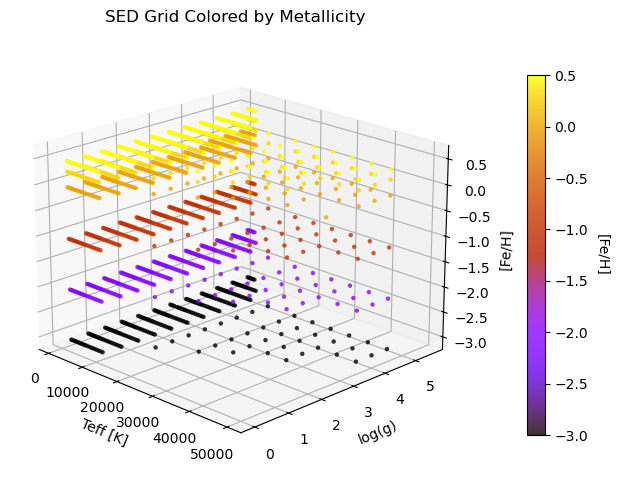

In [138]:
# %matplotlib widget
star = STAR_PDF('/home/hallouin/Documents/t_hall/lephare/simulated_star_sed/bt_spectra/bt_star_sed_full.list')
star.make_sed_grid()
star.plot_sed_grid()

Test

In [151]:
chi2_values = np.loadtxt("/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/DESstars_BT_DES_full_PDFstar.prob")
# chi2_values = np.loadtxt("/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/DC1_BT_LSST_full_PDFstar.prob")

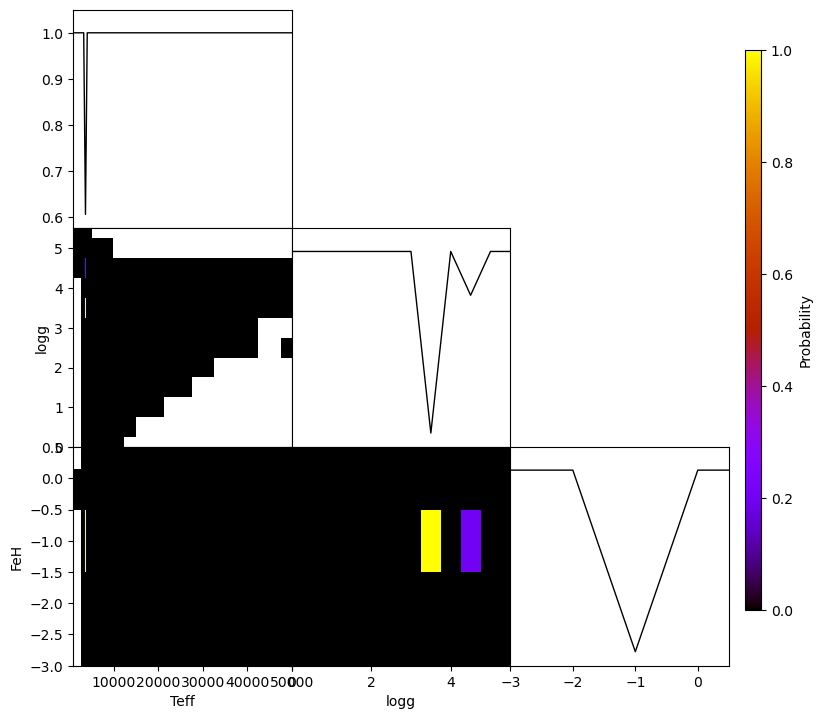

In [153]:
%matplotlib inline

grid = star.build_chi2_grid(chi2_values[218,1:]) #56 #96 #9 #99

star.plot_min_chi2(grid, to_prob=True, full=True)#, cmap = 'gist_stern')

## PDF examples

### PDFs from 1D (**Teff**) sed array

### PDFs from 2D (**Teff** , **log(g)**) sed grid

### PDFs from 3D (**Teff** , **log(g)** , **Fe/H**) sed grid